# 0.0 IMPORTS

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import math
import datetime

from matplotlib             import gridspec
from tabulate               import tabulate
from IPython.display        import Image
from scipy                  import stats  as ss
from boruta                 import BorutaPy
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model   import LinearRegression, Lasso
%matplotlib inline

## 0.1. Helper Functions

In [205]:
def mean_absolute_percentage_error1(y, yhat):
    mape = np.abs(yhat - y) / y
    return np.mean(mape, axis=0)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error1(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])
                         
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    # \chi ^{2} is derived from Pearson's chi-squared test
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    phi2corr  = max(0, phi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)

    # Varia de 0 a 1
    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

## 0.2. Loading df1

In [3]:
df_sales_raw = pd.read_csv('../data/rossmann-store-sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/rossmann-store-sales/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# show first 5 rows
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [4]:
# Pra não precisar rodar o notebook novamente do zero
# A cada nova seção é recomendado criar uma cópia do conjunto de dados
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# Converter colunas do estilo camel case para snake case
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [6]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 1.2 Data Dimension

In [7]:
print('Number of Rows {}'.format(df1.shape[0]))
print('Number of Cols {}'.format(df1.shape[1]))

Number of Rows 1017209
Number of Cols 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()
# Maneiras de tratar NAs
# 1. Descartar -> rápido mas há perda de dados, podendo prejudicar a performance do modelo
# 2. Usando algoritmos de ML -> Substituir as colunas vazia pelo próprio comportamento da coluna
# 3. Entendendo o negócio pode haver uma regra para preencher os dados faltantes

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NAs

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# Whereas when competition_distance = Na, there is no close competitor
# competition_distance pode estar vazia porque pode não ter um compedidor próximo, esqueceram de preencher
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# Não tem muita lógica, mas foi feita as assumptions abaixo
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                         
# promo2_since_week               
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval                  
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis =1) 

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types
Ao criar novas colunas é importante checar de novo o tipo das colunas, pois o resultado das operações pode ter alterado o tipo original

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Staristical


In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
num_attributes.describe().T
ct1 = pd.DataFrame(num_attributes.mean()).T
ct2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - sdt, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.std()).T
d2 = pd.DataFrame(num_attributes.min()).T
d3 = pd.DataFrame(num_attributes.max()).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


/home/leonam/anaconda3/envs/DataScience_Em_Producao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


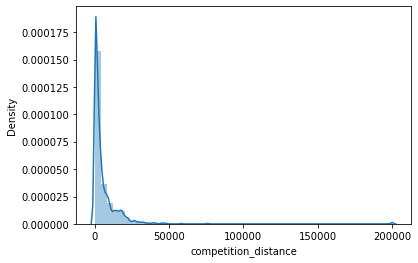

In [16]:
sns.distplot(df1['competition_distance']);

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# Boxplots são úteis para vizualizar medidas de dispersão e tendencia central em um gráfico apenas

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

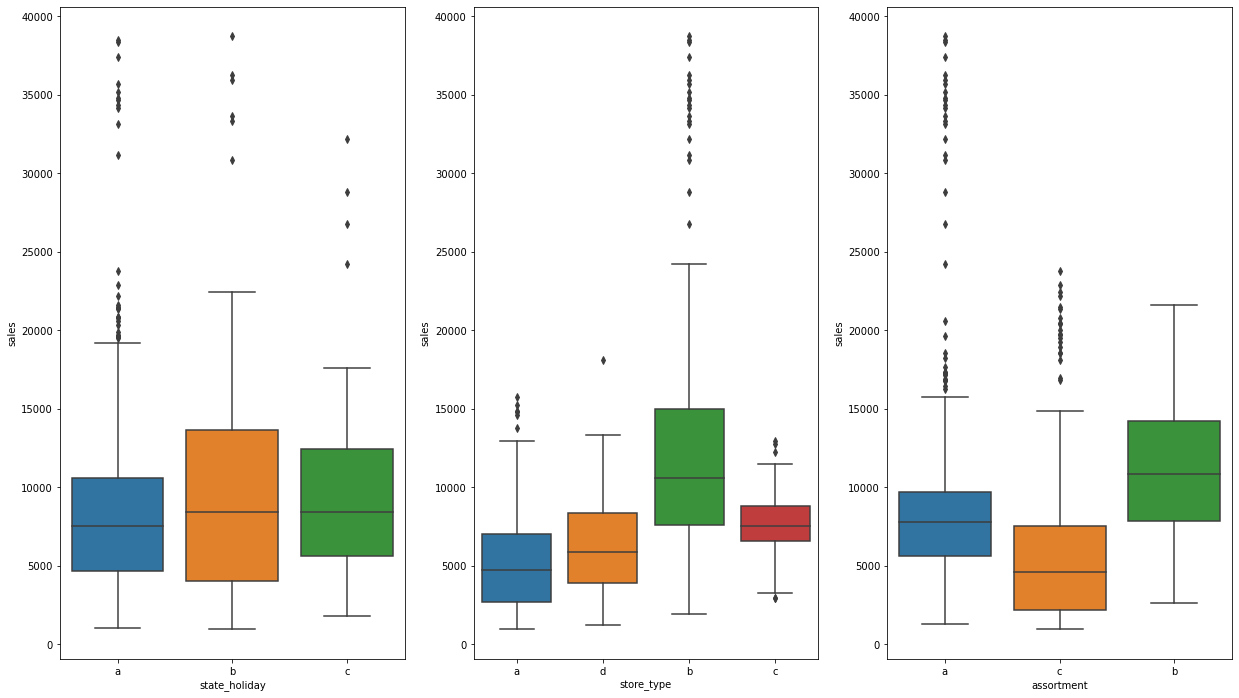

In [18]:
# Filtrar apenas registros em dias comerciais com vendas superiores a 0
aux1 =df1[(df1.state_holiday !='0' ) & (df1.sales > 0)]

# Boxplots
# Linha do meio é a mediana
# box limitado pelos 25th quartil and 75th quartil
# Outliers fora do boxplot

fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row
ax2 = fig.add_subplot(specs[0,1])  # First row Second Column
ax3 = fig.add_subplot(specs[0,2])  # First row Third Column

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=ax1)

sns.boxplot(x='store_type', y='sales', data=aux1, ax=ax2)

sns.boxplot(x='assortment', y='sales', data=aux1, ax=ax3)

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental das Hipóteses

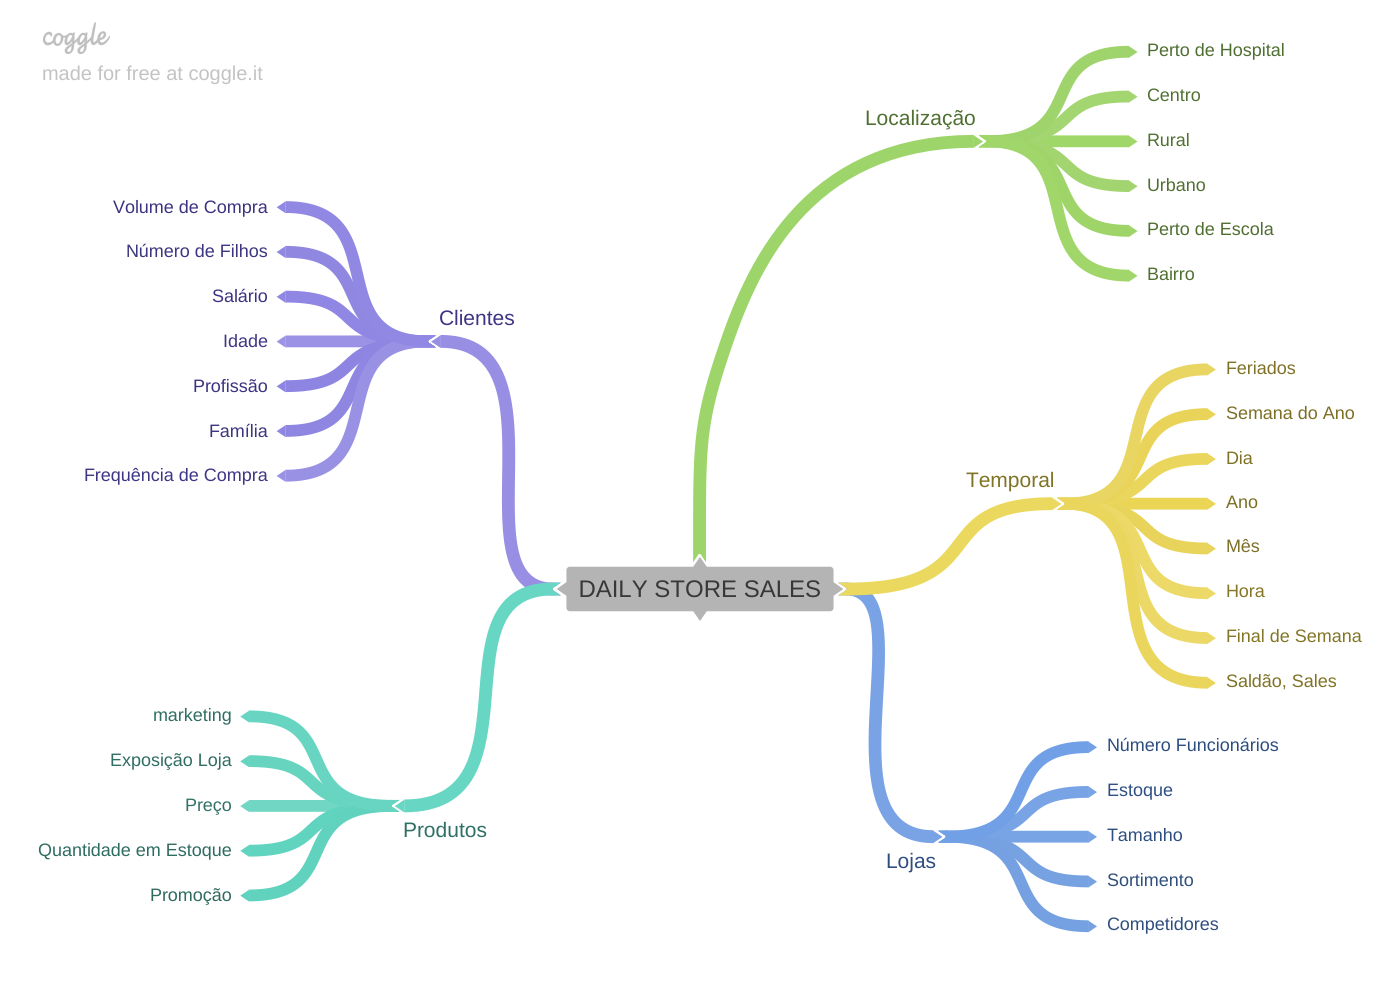

In [19]:
Image('../img/MindMapHypothesis.png')

## 2.1 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expõem mais os produtos na vitrine deveriam vender mais

**3.** Lojas com preços menores dos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais

**5.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de Hipóteses

Como prioriar as hipóteses?
	
	1. Você possui os dados da hipótese agora?

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

##

## 2.3 Feature Engineering

In [20]:
df2 = df1.copy()

In [21]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype(np.int64)

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/np.timedelta64(1,'M'))
# df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo sinxe
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# slow way
# df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7)) 
df2['promo_since'] = pd.to_datetime(df2['promo_since'] + '-1', format='%Y-%W-%w') - datetime.timedelta(days=7)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/np.timedelta64(1,'W'))
# df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# # assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [22]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.000000,280.000000,558.000000,838.000000,1115.000000
day_of_week,1017209.0,3.998341,1.997391,1.000000,2.000000,4.000000,6.000000,7.000000
sales,1017209.0,5773.818972,3849.926175,0.000000,3727.000000,5744.000000,7856.000000,41551.000000
customers,1017209.0,633.145946,464.411734,0.000000,405.000000,609.000000,837.000000,7388.000000
open,1017209.0,0.830107,0.375539,0.000000,1.000000,1.000000,1.000000,1.000000
promo,1017209.0,0.381515,0.485759,0.000000,0.000000,0.000000,1.000000,1.000000
school_holiday,1017209.0,0.178647,0.383056,0.000000,0.000000,0.000000,0.000000,1.000000
competition_distance,1017209.0,5935.442677,12547.652996,20.000000,710.000000,2330.000000,6910.000000,200000.000000
competition_open_since_month,1017209.0,6.786849,3.311087,1.000000,4.000000,7.000000,10.000000,12.000000
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.000000,2008.000000,2012.000000,2014.000000,2015.000000


# 3.0 FEATURE FILTERING

In [23]:
df3 =df2.copy()

## 3.1. Filtragem da Linhas

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção da Colunas

In [25]:
# Para realizar previsão de vendas teria que ter a quantidade de customers no futuro
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Step 04 - Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

/home/leonam/anaconda3/envs/DataScience_Em_Producao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

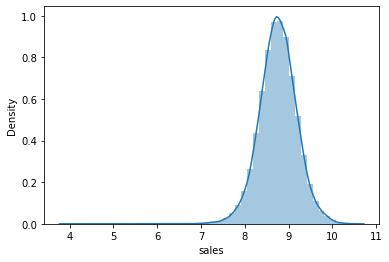

In [27]:
sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Numerical Variable

<ipython-input-28-e01e2f737bee>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(bins=25, ax=ax);
/home/leonam/anaconda3/envs/DataScience_Em_Producao/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


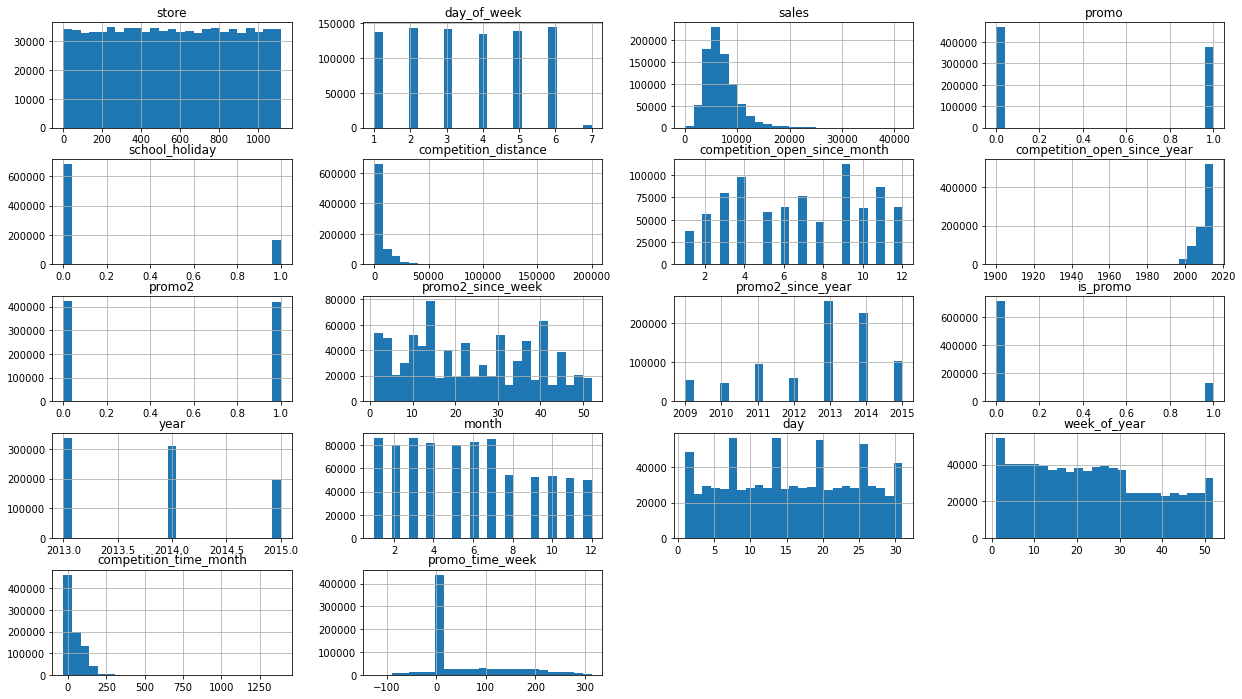

In [28]:
fig = plt.figure(figsize=(21,12));
ax = fig.add_subplot();

num_attributes = df4.select_dtypes(include=['int64', 'float64']);

num_attributes.hist(bins=25, ax=ax);

### 4.1.3. Categorical Variable

In [29]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


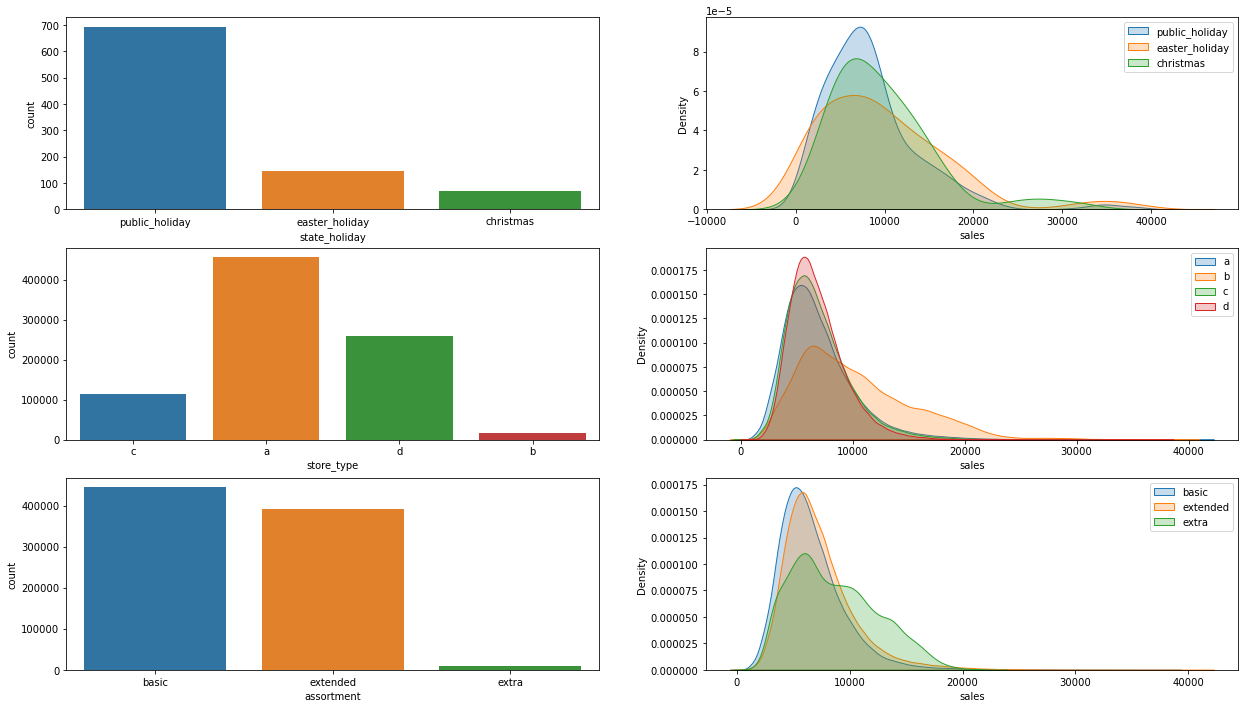

In [30]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=2, nrows=3, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row First Column
ax2 = fig.add_subplot(specs[0,1])  # First row Second Column
ax3 = fig.add_subplot(specs[1,0])  # Second row First Column
ax4 = fig.add_subplot(specs[1,1])  # Second row Second Column
ax5 = fig.add_subplot(specs[2,0])  # Third row First Column
ax6 = fig.add_subplot(specs[2,1])  # Third row Second Column

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], ax=ax1)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade= True, ax=ax2)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade= True, ax=ax2)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade= True, ax=ax2)
ax2.legend()

sns.countplot(x=df4['store_type'], ax=ax3)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade= True, ax=ax4)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade= True, ax=ax4)
ax4.legend()

sns.countplot(x=df4['assortment'], ax=ax5)

# plots de densidade de distribuição
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade= True, ax=ax6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade= True, ax=ax6)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade= True, ax=ax6)
ax6.legend()

## 4.2. Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais, na média.
**Verdadeira** lojas com maior sortimento vendem mais na média 

/home/leonam/anaconda3/envs/DataScience_Em_Producao/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='year_week'>

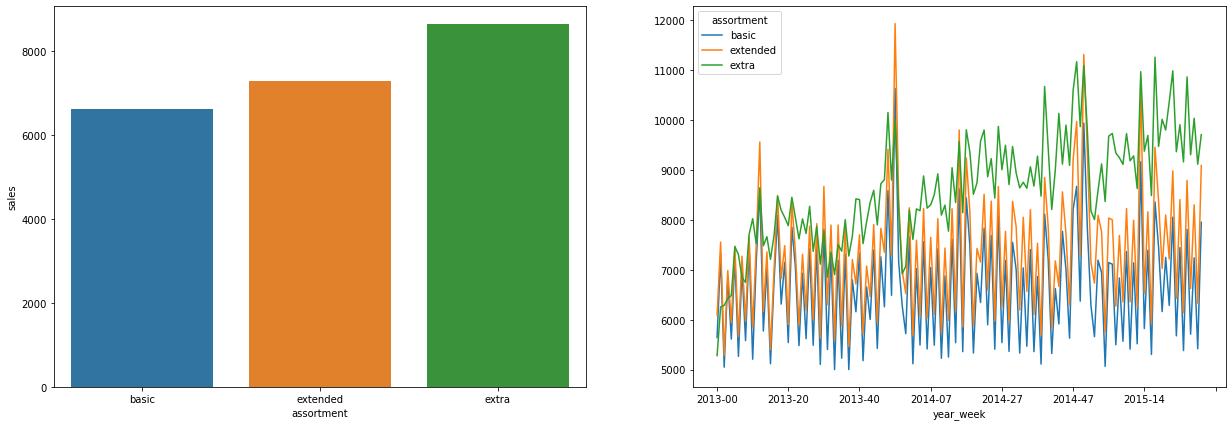

In [31]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=2, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  
ax2 = fig.add_subplot(specs[0,1])   


aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, ax=ax1); 

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax2)

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falso**, lojas com vendedores próximos vendem mais na média

<AxesSubplot:>

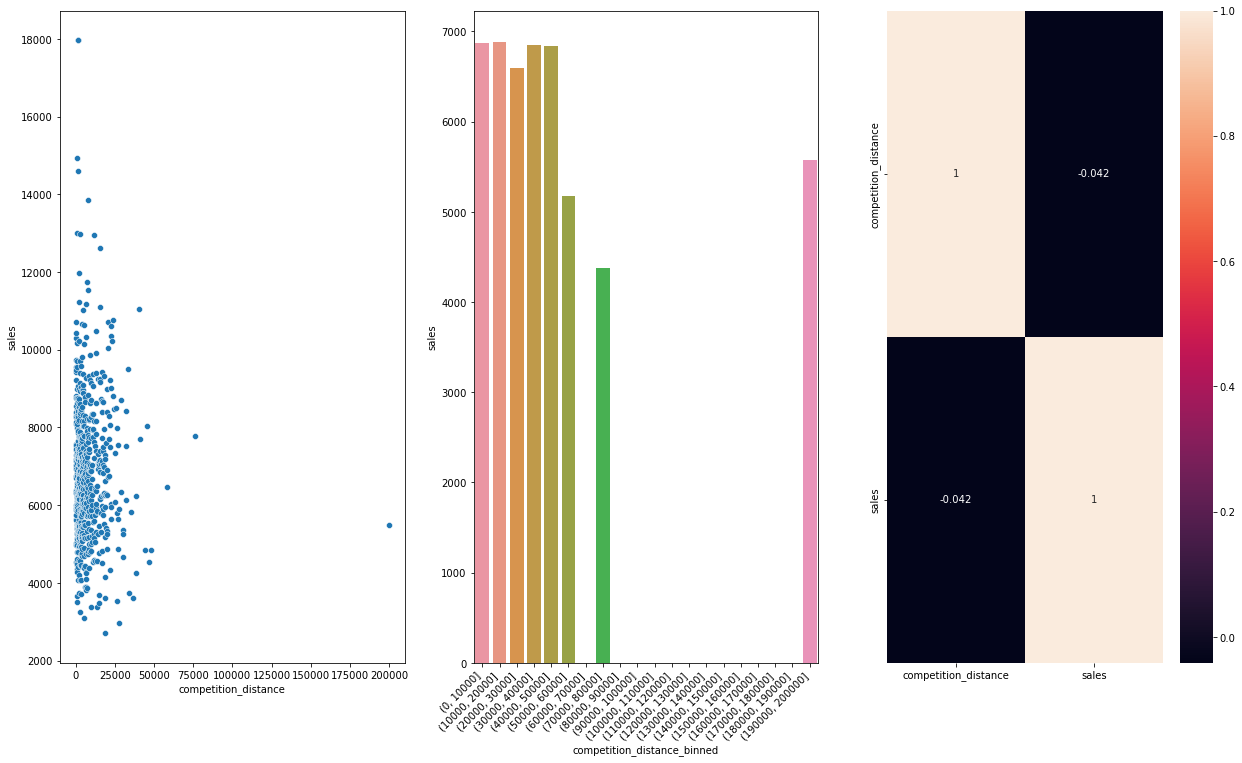

In [32]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 


aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

sns.scatterplot(data=aux1, x='competition_distance', y='sales', ax=ax1)

bins = list(np.arange(0, 210000, 10000))

aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()


sns.barplot(x='competition_distance_binned', y='sales', data=aux2, ax=ax2); 
ax2.set_xticklabels(labels=aux2['competition_distance_binned'], rotation=45, ha='right')

sns.heatmap(df4[['competition_distance', 'sales']].corr(method='pearson'), annot=True, ax=ax3)

### **H3.** Lojas com competidores à mais tempo deveriam vender mais na média.
**Verdadeiro**

<AxesSubplot:>

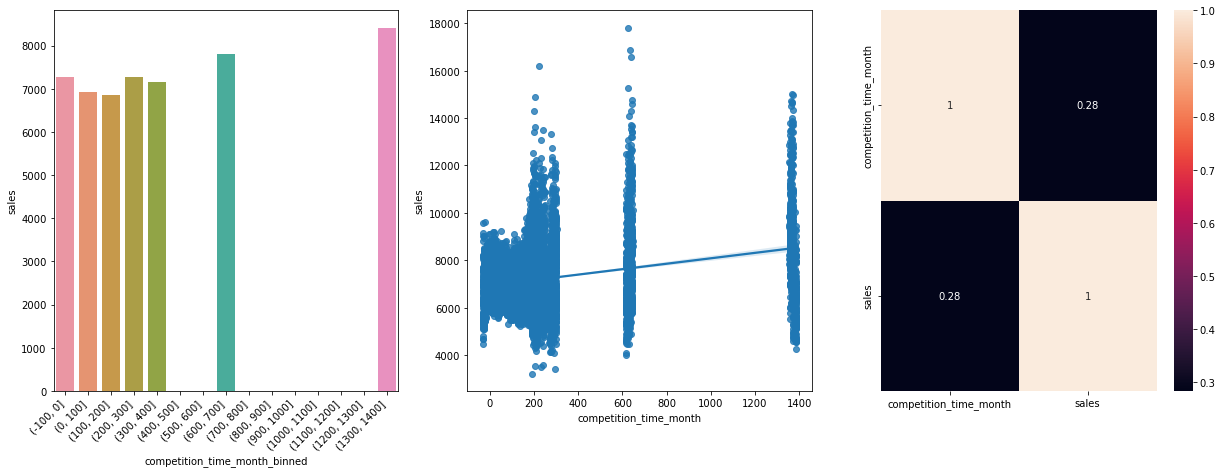

In [33]:
fig = plt.figure(figsize=(21,7))
specs = gridspec.GridSpec(ncols=3, nrows=1, figure = fig)

ax1 = fig.add_subplot(specs[0,0])  # First row 
ax2 = fig.add_subplot(specs[0,1])  # Second row 
ax3 = fig.add_subplot(specs[0,2])  # Third row 

aux1 = df4.copy()
bins = list(np.arange(-100, 1500, 100))
aux1['competition_time_month_binned'] = pd.cut(df4['competition_time_month'], bins=bins)
aux2 = aux1[['competition_time_month_binned', 'sales']].groupby('competition_time_month_binned').mean().reset_index()

sns.barplot( x='competition_time_month_binned', y='sales', data=aux2, ax=ax1 );
ax1.set_xticklabels(labels=aux2['competition_time_month_binned'], rotation=45, ha='right');

aux3 = aux1[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
sns.regplot(x='competition_time_month', y='sales', data=aux3, ax= ax2)

sns.heatmap(aux3.corr(method='pearson'), annot=True, ax=ax3)

### **H4.** Lojas com promoções dos produtos por mais tempo deveriam vender mais.

**Verdadeiro** para promoções extendidas e **falso** para promoções regulares, pois para períodos de promoções regulares a correlação é quase nula

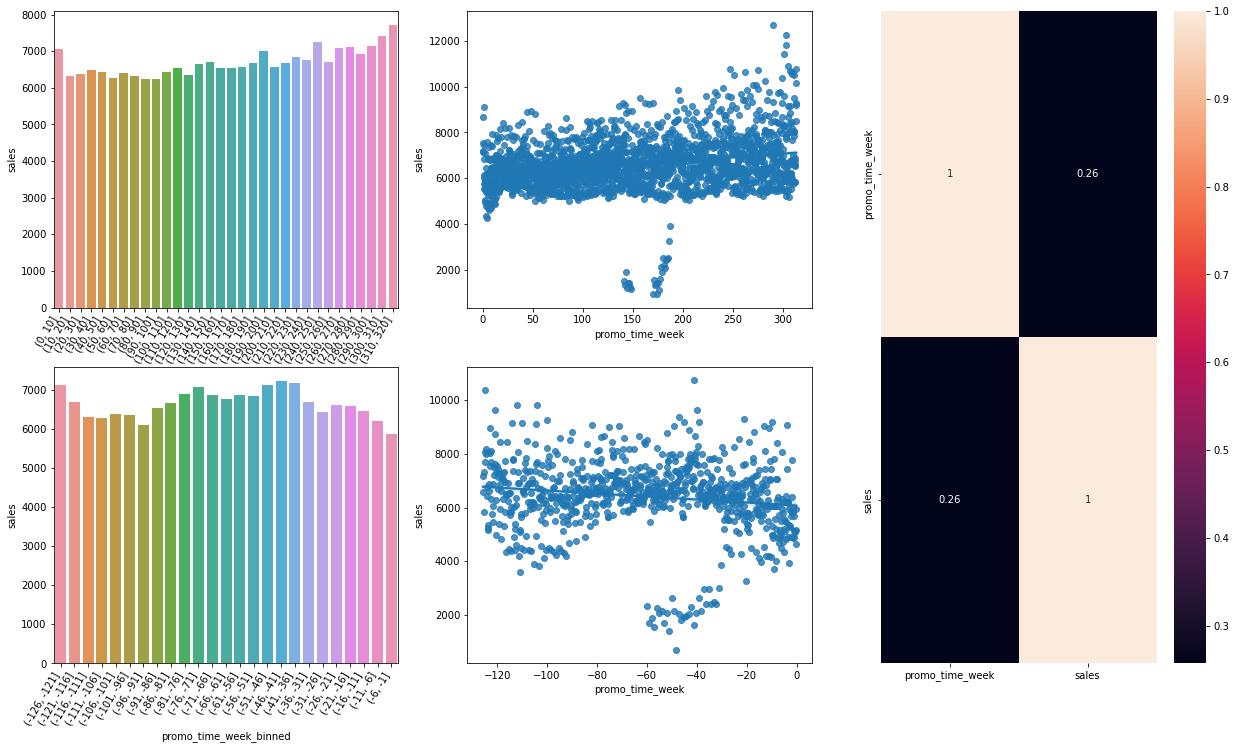

In [34]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=3, nrows=2, figure = fig)

ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[0,1])
ax3 = fig.add_subplot(specs[1,0])
ax4 = fig.add_subplot(specs[1,1])
ax5 = fig.add_subplot(specs[:,2])

bins = list(np.arange(0, 330, 10)); # promo extendido
aux1 = df4[df4['promo_time_week'] >= 0].copy()
aux1['promo_time_week_binned']= pd.cut(aux1['promo_time_week'], bins=bins)
aux2 = aux1[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot( x='promo_time_week_binned', y='sales', data=aux2, ax=ax1)
ax1.set_xticklabels(labels=aux2['promo_time_week_binned'], rotation=60, ha='right')

aux3 = aux1[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
sns.regplot(x='promo_time_week', y='sales', data=aux3, ax= ax2)

bins = list(np.arange(-126, 0, 5)); # promo regular
aux4 = df4[df4['promo_time_week'] < 0].copy()
aux4['promo_time_week_binned'] = pd.cut(aux4['promo_time_week'], bins=bins)
aux5 = aux4[['promo_time_week_binned', 'sales']].groupby('promo_time_week_binned').mean().reset_index()
sns.barplot( x='promo_time_week_binned', y='sales', data=aux5, ax=ax3)
ax3.set_xticklabels(labels=aux5['promo_time_week_binned'], rotation=60, ha='right')

aux6 = aux4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
sns.regplot(x='promo_time_week', y='sales', data=aux6, ax= ax4)

sns.heatmap(aux3.corr(method='pearson'), annot=True, ax=ax5);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais

**Falso** Lojas com mais promocoes consecutivas vendem menos

In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


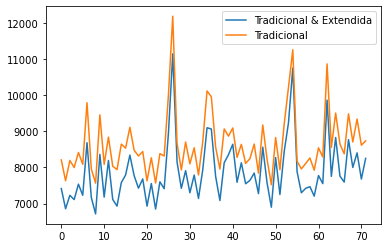

In [36]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa**, Lojas abertas durante a páscoa vendem mais na média

<AxesSubplot:xlabel='year', ylabel='sales'>

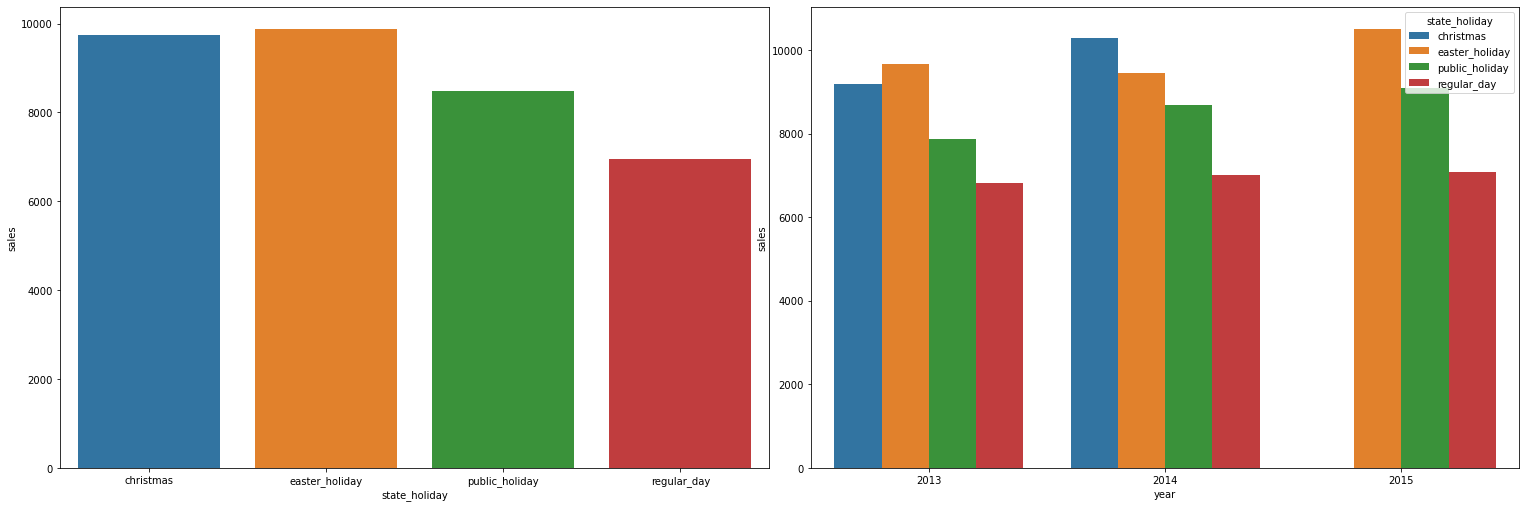

In [37]:
#define subplots
fig, ax = plt.subplots(1, 2, figsize=(21,7))
fig.tight_layout()

aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, ax=ax[0])

aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2,ax=ax[1])

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa**, as vendas das lojas diminuem com o passar dos anos

<AxesSubplot:>

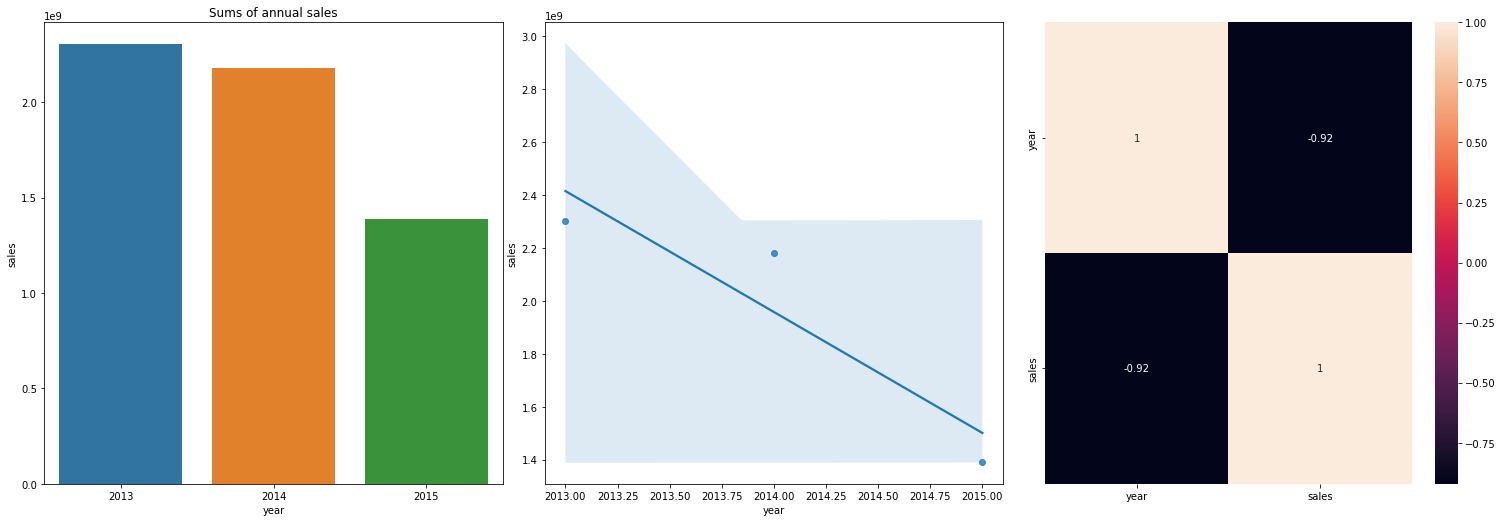

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.tight_layout()

# aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()
# sns.barplot(x='year', y='sales', data=aux1, ax=ax[0,0]).set(title='Average annual sales')
# sns.regplot(x='year', y='sales', data=aux1, ax=ax[0,1])
# sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[0,2])

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1, ax=ax[0]).set(title='Sums of annual sales')
sns.regplot(x='year', y='sales', data=aux1, ax=ax[1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])

### **H9.** Lojas demveriam vender mais no segundo semestre do ano.
**Verdadeiro**, na média, as lojas vendem mais no segundo semestre

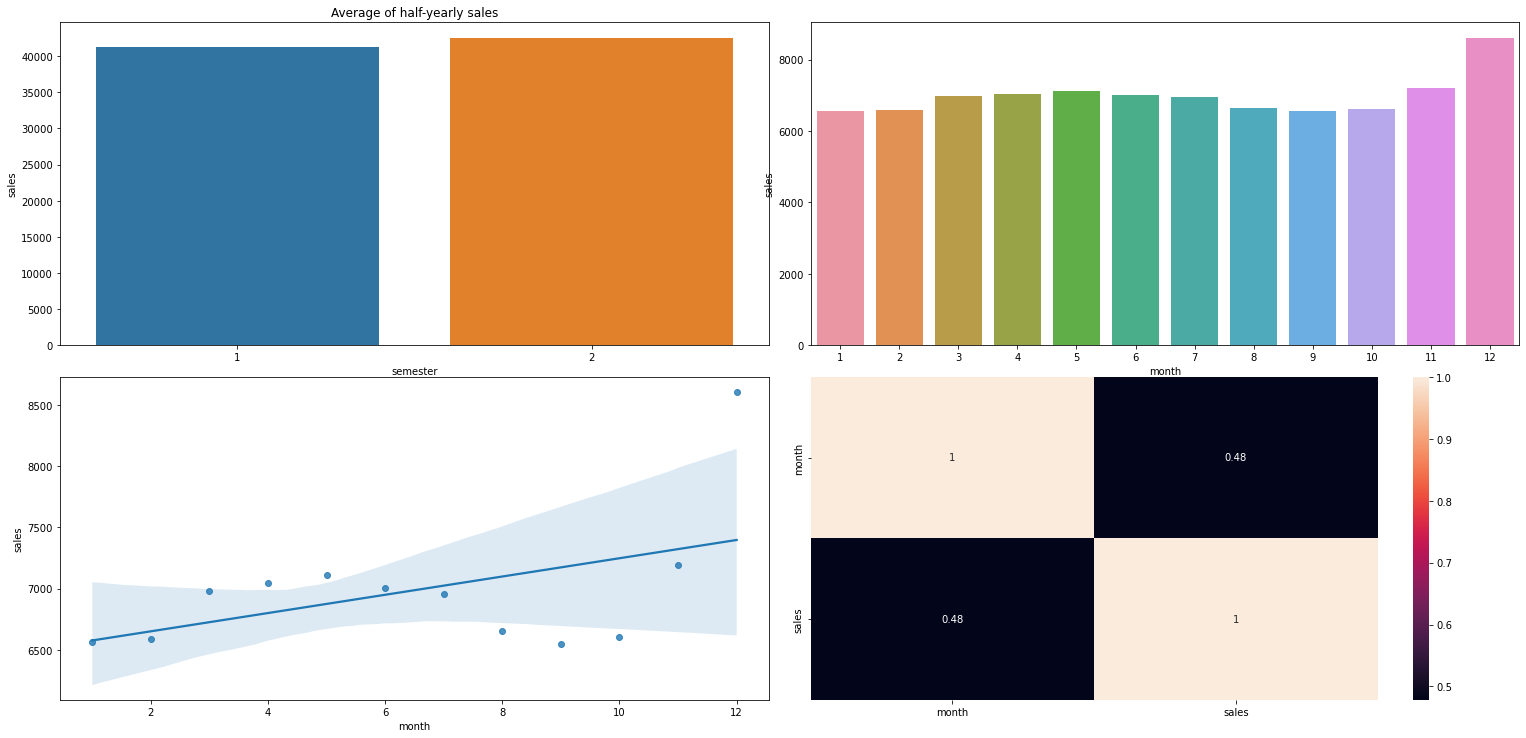

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()
avg_sales_first_sem = aux1[aux1['month'] <= 6]['sales'].sum()
avg_sales_second_sem = aux1[aux1['month'] > 6]['sales'].sum()

df= pd.DataFrame(data= {'sales': [avg_sales_first_sem, avg_sales_second_sem], 'semester': [1, 2]})

sns.barplot(x='semester', y='sales', data =df, ax=ax[0,0]).set(title='Average of half-yearly sales')

sns.barplot( x='month', y='sales', data=aux1 , ax=ax[0,1]);

sns.regplot( x='month', y='sales', data=aux1, ax=ax[1,0]);

sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

<AxesSubplot:xlabel='before_after_10', ylabel='sales'>

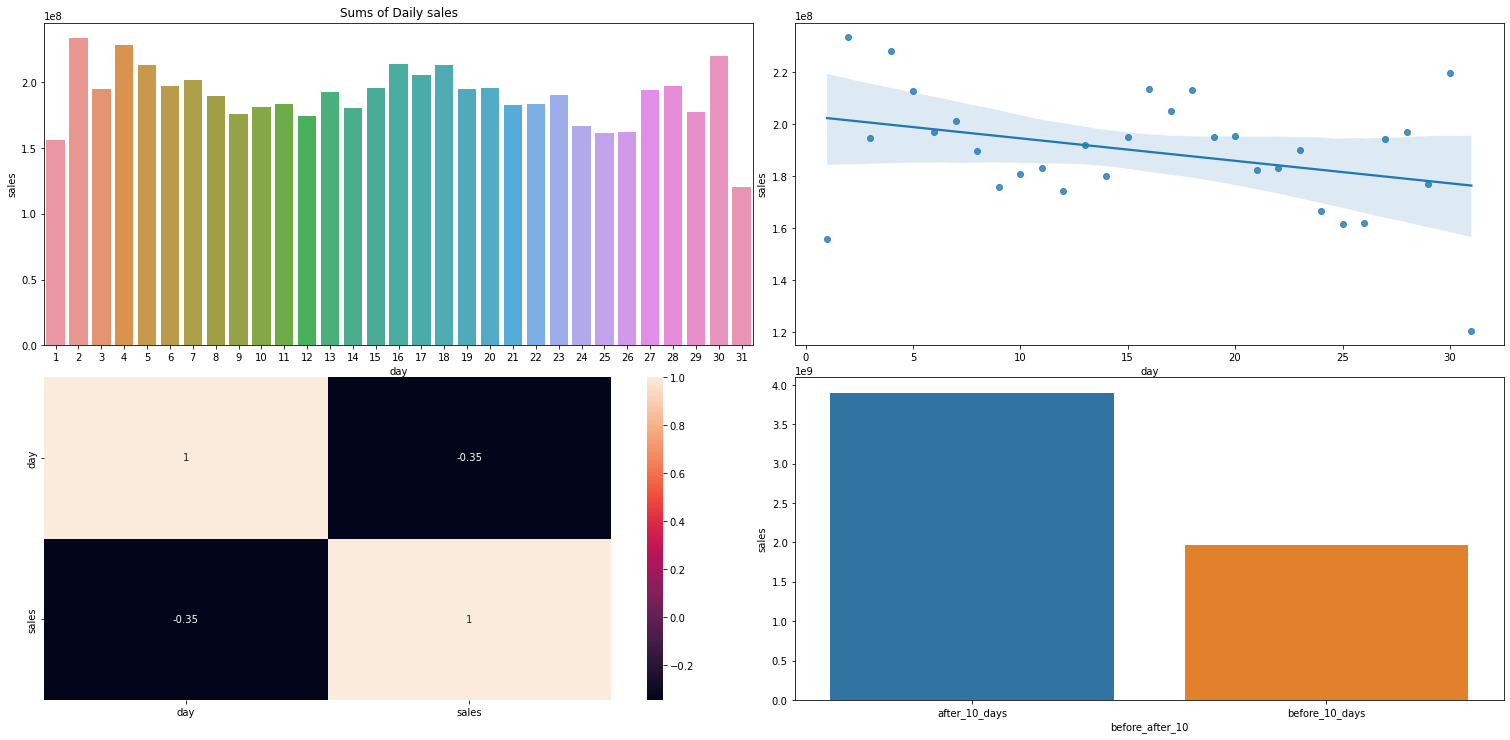

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1, ax=ax[0,0]).set(title='Sums of Daily sales')
sns.regplot(x='day', y='sales', data=aux1, ax=ax[0,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[1,0])

aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after_10', 'sales']].groupby( 'before_after_10' ).sum().reset_index()
sns.barplot(x='before_after_10', y='sales', data=aux2, ax=ax[1,1])

### **H11.** Lojas deveriam vender menos nos finais de semana.

**VERDADEIRA** Lojas vendem menos nos final de semana

<AxesSubplot:>

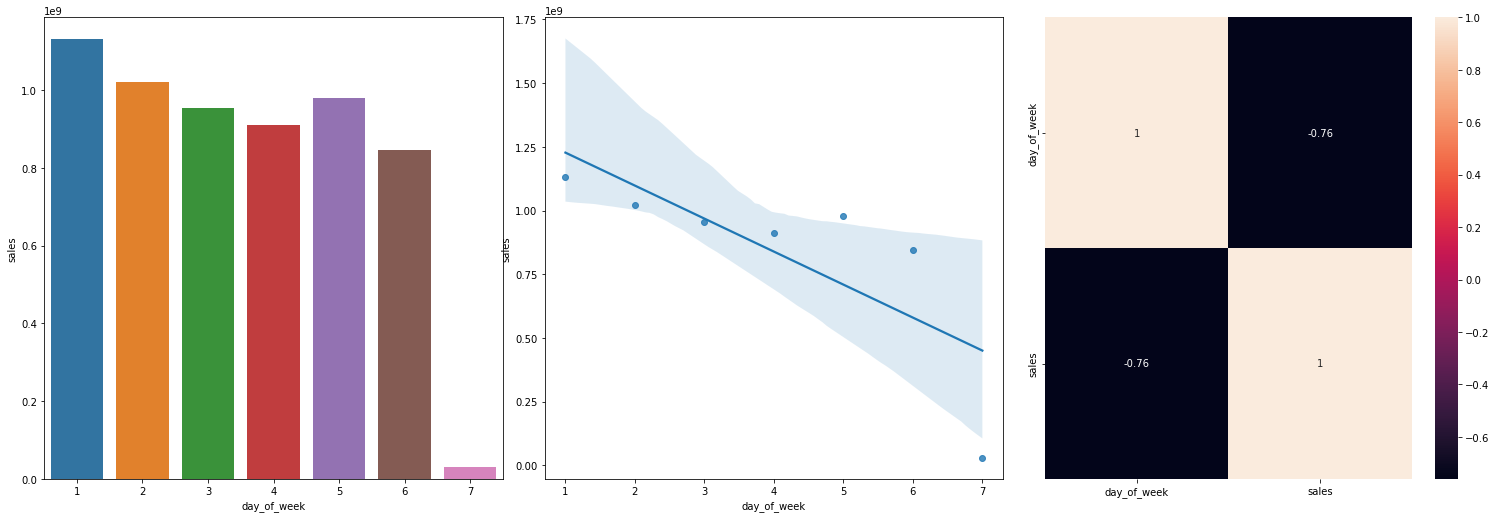

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
fig.tight_layout()


aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1, ax=ax[0])
sns.regplot(x='day_of_week', y='sales', data=aux1, ax=ax[1])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax[2])

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de Agosto

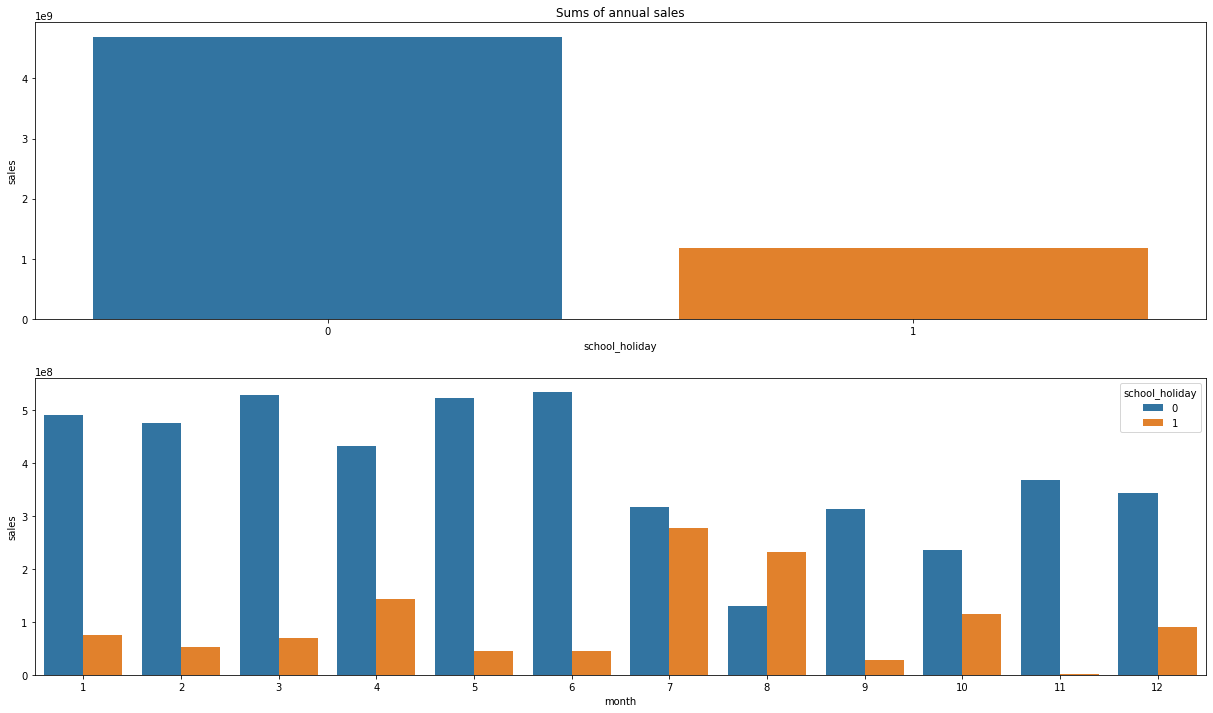

In [42]:
fig = plt.figure(figsize=(21,12))
specs = gridspec.GridSpec(ncols=1, nrows=2, figure = fig)

ax1 = fig.add_subplot(specs[0])
ax2 = fig.add_subplot(specs[1])

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1, ax=ax1).set(title='Sums of annual sales')
# sns.regplot(x='school_holiday', y='sales', data=aux1, ax=ax2)
# sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax3)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 , ax=ax2);

### 4.2.1 Resumo das Hipóteses

In [43]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Verdadeira', 'Alta'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Verdadeira', 'Media'],
      ['H4', 'Verdadeira', 'Media'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Media'],
      ['H10', 'Verdadeira', 'Media'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Media
H3           Verdadeira   Media
H4           Verdadeira   Media
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Media
H10          Verdadeira   Media
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

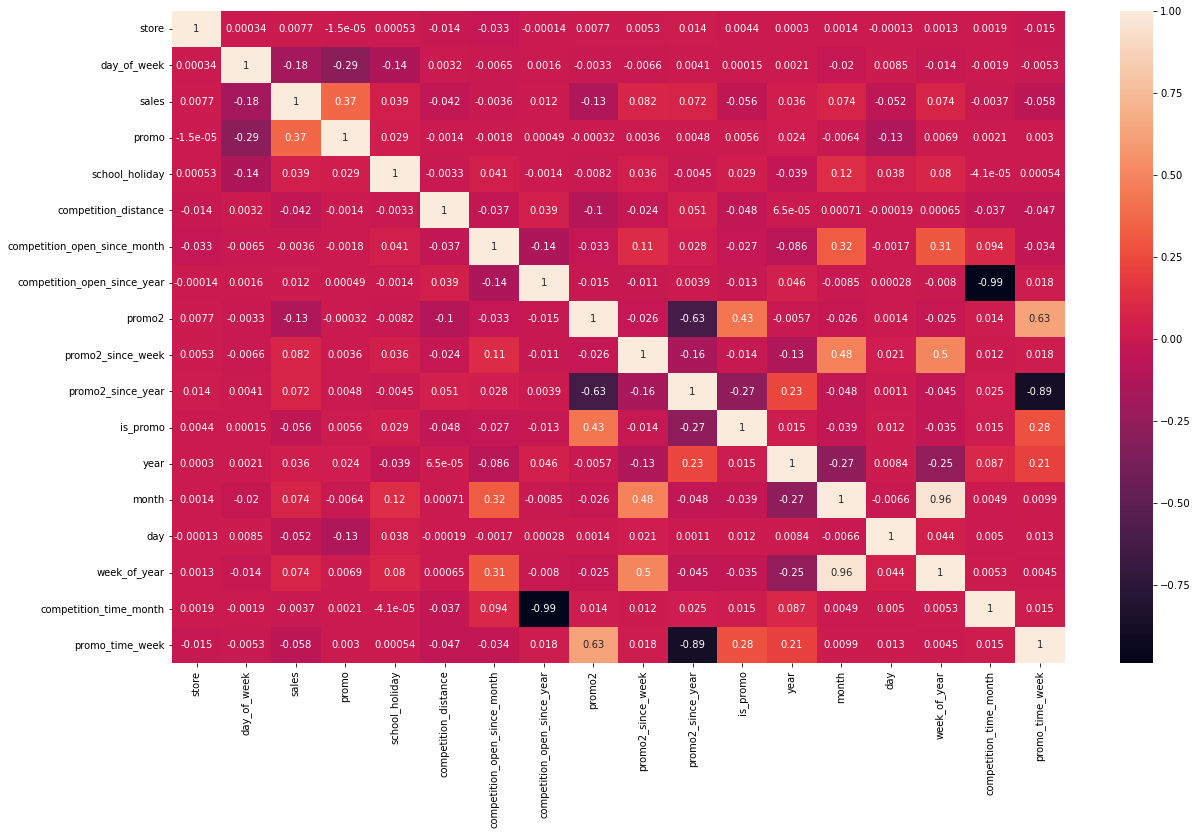

In [44]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

# creating mask
mask = np.triu(np.ones_like(num_attributes.corr()))
 
# plotting a triangle correlation heatmap
sns.heatmap(num_attributes.corr(method='pearson'), annot=True, ax=ax)

### 4.3.2 Categorical Attributes

In [45]:
cat_attributes = df4.select_dtypes(include='object')
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

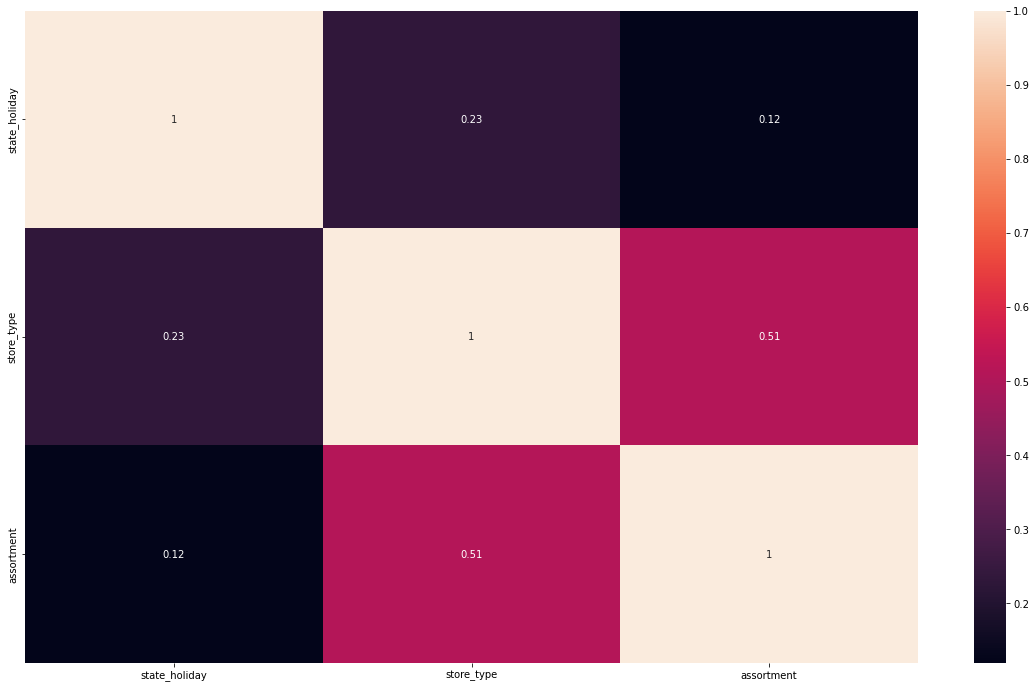

In [46]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

# only categorical data
a = a.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

sns.heatmap(d, annot = True, ax=ax)

# 5.0. Passo 05 - Data Preparation

In [75]:
df5 = df4.copy()

## 5.1 Normalizacao

De acordo com a análise univariada das variáveis numéricas (seção 4.1.2), não há nenhuma variável com distribuição normal ou próxima de normal. 

## 5.2 Rescaling

In [76]:
a = df5.select_dtypes(include=['int64', 'float64'])

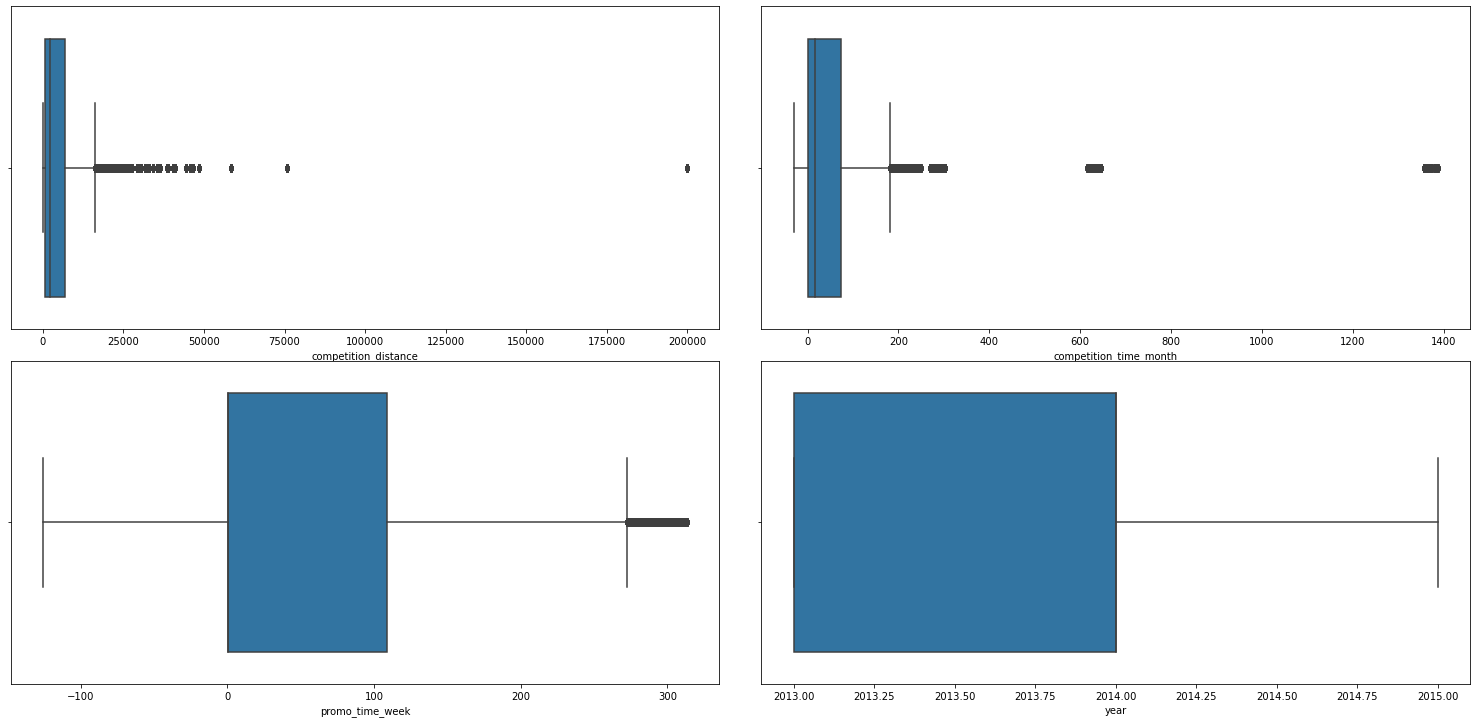

In [77]:
fig, ax = plt.subplots(2, 2, figsize=(21,10))
fig.tight_layout()


sns.boxplot(x=df5['competition_distance'], ax=ax[0,0])
sns.boxplot(x=df5['competition_time_month'], ax=ax[0,1])
sns.boxplot(x=df5['promo_time_week'], ax=ax[1,0])
sns.boxplot(x=df5['year'], ax=ax[1,1]);

In [78]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

# year
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

## 5.3 Transformacao

### 5.3.1 Encoding

In [79]:
cat_attributes = df5.select_dtypes(include='object')
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [80]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment -  Ordinal Encoding
assotment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assotment_dict)

### 5.3.2 Response Variable Transformation

/home/leonam/anaconda3/envs/DataScience_Em_Producao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

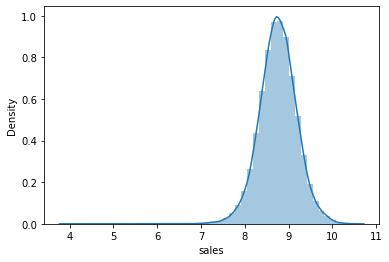

In [81]:
df5['sales'] = np.log1p(df5['sales'])

sns.distplot(df5['sales'])

### 5.3.2 Nature Transformation

In [82]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. *np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. *np.pi/12)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. *np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. *np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. *np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. *np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. *np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. *np.pi/52)))

In [83]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984


# 6.0 passo 06 - Feature Selection

In [84]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test set

In [85]:
cols_drop = ['week_of_year', 'day', 'day_of_week', 'month', 'competition_since', 'promo_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

Como estamos trabalhando com um problema temporal, não podemos selecionar aleatóriamente quais linhas pertecenrão ao conjunto de treinamento  e quais linhas pertencerão ao conjunto de testes. Como o objetivo é fazer uma previsão das vendas nas próximas 6 semanas, as últimas 6 semanas de venda serão utilizadas como teste e os dados anteriores serão utilizados com treino.

In [86]:
data_limit = df6[['store', 'date']].groupby('store').max()['date'].max() - datetime.timedelta(days=6*7)

# df_sample = df6.sample(n=400000)

# training dataset
X_train = df6[df6['date'] < data_limit]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= data_limit]
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [87]:
X_train.shape

(802942, 29)

In [ ]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [88]:
# No primeiro cliclo do CRISP será utilizado apenas as variáveis fornecidas pelo Borutaooo

cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
# feat_to_add = ['date', 'sales']

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Passo 07 - Machine Learning Modelling

In [89]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model

In [183]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales' : 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [203]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.511888,0.291615,2663.307498


Observa-se que o RMSE aumentou ao comparar com o modelo baseline que calcula a media. Assim chega-se a conclusão que os dados possuem um comportamento não linear.

## 7.3 Linear Regression Regularized Model - Lasso

In [202]:
# model
lrr = Lasso(alpha=0.001).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1864.110217,0.287186,2685.92071
